## data processing

In [7]:
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import pearsonr, entropy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [54]:
# load the data and show the head
data = pd.read_csv("RFLFSODataFull.csv")
data.head()
# check the data type and not null data
data.info()
# Display basic statistical details
data.describe()
# The number of each values of frequency feature
data['Frequency'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91379 entries, 0 to 91378
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   FSO_Att                91379 non-null  float64
 1   RFL_Att                91379 non-null  float64
 2   AbsoluteHumidity       91379 non-null  float64
 3   AbsoluteHumidityMax    91379 non-null  float64
 4   AbsoluteHumidityMin    91379 non-null  float64
 5   Distance               91379 non-null  float64
 6   Frequency              91379 non-null  int64  
 7   Particulate            91379 non-null  float64
 8   ParticulateMax         91379 non-null  float64
 9   ParticulateMin         91379 non-null  float64
 10  RainIntensity          91379 non-null  float64
 11  RainIntensityMax       91379 non-null  float64
 12  RainIntensityMin       91379 non-null  float64
 13  RelativeHumidity       91379 non-null  float64
 14  SYNOPCode              91379 non-null  int64  
 15  Te

Frequency
83500000000    45690
73500000000    45689
Name: count, dtype: int64

In [55]:
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)

In [56]:
def train_models(data_by_synop, best_features, target, param_grid):
    """
    Train models for each SYNOPCode subset and calculate metrics.

    Parameters:
    data_by_synop (dict): Dictionary with subsets of data grouped by SYNOPCode.
    best_features (dict): Dictionary of selected features for each SYNOPCode.
    target (str): Target column to predict ('RFL_Att' or 'FSO_Att').
    param_grid (dict): Parameter grid for hyperparameter tuning.

    Returns:
    dict: Trained models for each SYNOPCode.
    list: True values from all test sets combined.
    list: Predicted values from all test sets combined.
    float: Overall R² score.
    float: Overall RMSE.
    """
    models = {}
    total_y_true = []
    total_y_pred = []

    for key, data_subset in data_by_synop.items():
        features = best_features[key]
        X = data_subset[features]
        y = data_subset[target]

        # Split the data into training and test sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
        )

        # Perform hyperparameter tuning
        model = RandomForestRegressor(random_state=42)
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
        grid_search.fit(X_train, y_train)

        # Save the best model
        best_model = grid_search.best_estimator_
        models[key] = best_model

        # Make predictions on the test set
        y_pred = best_model.predict(X_test)

        # Accumulate true and predicted values
        total_y_true.extend(y_test)
        total_y_pred.extend(y_pred)

        # Print performance for the current subset
        r2 = r2_score(y_test, y_pred)
        rmse = root_mean_squared_error(y_test, y_pred)
        print(f"Best model for {key}: {grid_search.best_params_}")
        print(f"R² for {key}: {r2:.4f}, RMSE: {rmse:.4f}")

    # Calculate overall metrics
    overall_r2 = r2_score(total_y_true, total_y_pred)
    overall_rmse = root_mean_squared_error(total_y_true, total_y_pred)

    print(f"Overall Model - R² Score: {overall_r2:.4f}")
    print(f"Overall Model - RMSE: {overall_rmse:.4f}")

    return models, total_y_true, total_y_pred, overall_r2, overall_rmse


## FSO_Pre_RFL Model

In [57]:
# the SYNOCode and the best select features
data_by_synop = {
    'data_0': train_data[train_data['SYNOPCode'] == 0],
    'data_3': train_data[train_data['SYNOPCode'] == 3],
    'data_4': train_data[train_data['SYNOPCode'] == 4],
    'data_5': train_data[train_data['SYNOPCode'] == 5],
    'data_6': train_data[train_data['SYNOPCode'] == 6],
    'data_7': train_data[train_data['SYNOPCode'] == 7],
    'data_8': train_data[train_data['SYNOPCode'] == 8]
}

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7, 10]
}

In [58]:
best_features_fso = {
    'data_0': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature'],
    'data_3': ['VisibilityMax', 'RelativeHumidity', 'Distance', 'Time'],
    'data_4': ['Distance', 'TemperatureMin', 'TemperatureDifference', 'VisibilityMax', 'ParticulateMin', 'Time'],
    'data_5': ['VisibilityMax', 'Temperature', 'VisibilityMin', 'ParticulateMax'],
    'data_6': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature'],
    'data_7': ['Temperature', 'TemperatureDifference', 'Particulate', 'TemperatureMin', 'ParticulateMin'],
    'data_8': ['Distance', 'Visibility', 'AbsoluteHumidityMax', 'VisibilityMax', 'RelativeHumidity']
}

# Train FSO models
models_fso, total_y_true_fso, total_y_pred_fso, total_r2_fso, total_rmse_fso = train_models(
    data_by_synop=data_by_synop,
    best_features=best_features_fso,
    target='FSO_Att',
    param_grid=param_grid
)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_0: 0.6701, RMSE: 2.0258
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_3: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_3: 0.8630, RMSE: 2.9351
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_4: 0.9625, RMSE: 0.7895
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
R² for data_5: 0.8563, RMSE: 1.4001
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_6: 0.6648, RMSE: 2.5176
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_7: {

In [59]:
# Add the 'FSO_Pred' column to the dataset
for key, data_subset in data_by_synop.items():
    if key in models_fso:
        fso_model = models_fso[key]
        features_fso = best_features_fso[key]

        # Create a copy of the DataFrame to avoid the warning
        data_by_synop[key] = data_subset.copy()
        data_by_synop[key]['FSO_Pred'] = fso_model.predict(data_subset[features_fso])

In [60]:
best_features_rfl = {
    'data_0': ['Distance', 'Frequency', 'TemperatureMax', 'Time', 'FSO_Pred'],
    'data_3': ['RelativeHumidity', 'TemperatureDifference', 'Time', 'TemperatureMax', 'FSO_Pred'],
    'data_4': ['Visibility', 'Frequency', 'AbsoluteHumidity', 'VisibilityMin', 'Temperature', 'FSO_Pred'],
    'data_5': ['Distance', 'Frequency', 'AbsoluteHumidityMax', 'AbsoluteHumidity', 'ParticulateMax', 'FSO_Pred'],
    'data_6': ['Particulate', 'Distance', 'TemperatureMax', 'VisibilityMin', 'AbsoluteHumidity', 'FSO_Pred'],
    'data_7': ['Time', 'RelativeHumidity', 'RainIntensityMax', 'RainIntensity', 'TemperatureDifference', 'FSO_Pred'],
    'data_8': ['Distance', 'AbsoluteHumidityMax', 'TemperatureDifference', 'Frequency', 'RainIntensityMin', 'FSO_Pred']
}

# Train RFL models
models_rfl, total_y_true_rfl, total_y_pred_rfl, total_r2_rfl, total_rmse_rfl = train_models(
    data_by_synop=data_by_synop,
    best_features=best_features_rfl,
    target='RFL_Att',
    param_grid=param_grid
)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_0: 0.9368, RMSE: 0.6419
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_3: {'max_depth': 7, 'max_features': 'sqrt', 'n_estimators': 100}
R² for data_3: 0.9427, RMSE: 0.6514
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
R² for data_4: 0.8164, RMSE: 0.8249
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_5: 0.8932, RMSE: 0.9200
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
R² for data_6: 0.7343, RMSE: 2.0778
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_7: {'m

In [61]:
# === 1. Use FSO model for prediction on test set and add FSO_Pred feature === =
for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_fso:  # Check if a corresponding FSO model exists
        fso_model = models_fso[key]
        features_fso = best_features_fso[key]  # Extract the corresponding best features

        # The FSO model is used to predict the test set and FSO_Pred features are added
        fso_pred = fso_model.predict(test_subset[features_fso])
        test_data.loc[test_subset.index, 'FSO_Pred'] = fso_pred

print("The FSO model prediction is complete and the FSO_Pred feature has been added to the test data.")

The FSO model prediction is complete and the FSO_Pred feature has been added to the test data.


In [62]:
# === 2. Use the RFL model on the test set to make predictions and calculate performance ===
total_y_true_rfl = []
total_y_pred_rfl = []

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_rfl:  # Check if a corresponding RFL model exists
        rfl_model = models_rfl[key]
        features_rfl = best_features_rfl[key]

        # Extract the features and labels of the test set
        X_test_rfl = test_subset[features_rfl]
        y_test_rfl = test_subset['RFL_Att']

        # Use the RFL model for prediction
        y_pred_rfl = rfl_model.predict(X_test_rfl)

        # Accumulate true and predicted values
        total_y_true_rfl.extend(y_test_rfl)
        total_y_pred_rfl.extend(y_pred_rfl)

        print(f"RFL predict finished：{key}")

# === 3. Calculate the overall R² and RMSE ===
total_r2_rfl = r2_score(total_y_true_rfl, total_y_pred_rfl)
total_rmse_rfl = root_mean_squared_error(total_y_true_rfl, total_y_pred_rfl)

print(f"Total RFL Model - R2 Score: {total_r2_rfl:.4f}")
print(f"Total RFL Model - RMSE: {total_rmse_rfl:.4f}")

RFL predict finished：data_0
RFL predict finished：data_3
RFL predict finished：data_4
RFL predict finished：data_5
RFL predict finished：data_6
RFL predict finished：data_7
RFL predict finished：data_8
Total RFL Model - R2 Score: 0.8744
Total RFL Model - RMSE: 1.2139


In [63]:
# === 2. The RFL model is used on the test set to make predictions and calculate performance ===
performance_metrics = {}

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_rfl:
        rfl_model = models_rfl[key]
        features_rfl = best_features_rfl[key]

        X_test_rfl = test_subset[features_rfl]
        y_test_rfl = test_subset['RFL_Att']

        y_pred_rfl = rfl_model.predict(X_test_rfl)

        # calculate the R² and RMSE
        r2 = r2_score(y_test_rfl, y_pred_rfl)
        rmse = root_mean_squared_error(y_test_rfl, y_pred_rfl)

        # save the result
        performance_metrics[key] = {'R2': r2, 'RMSE': rmse}

        print(f"RFL predict finished：{key}")
        print(f"SYNOPCode {key} - R2 Score: {r2:.4f}")
        print(f"SYNOPCode {key} - RMSE: {rmse:.4f}")

# print the performance for each SYNOPCode
for synop_code, metrics in performance_metrics.items():
    print(f"SYNOPCode {synop_code} - R2 Score: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.4f}")


RFL predict finished：data_0
SYNOPCode data_0 - R2 Score: 0.9302
SYNOPCode data_0 - RMSE: 0.6727
RFL predict finished：data_3
SYNOPCode data_3 - R2 Score: 0.9521
SYNOPCode data_3 - RMSE: 0.6761
RFL predict finished：data_4
SYNOPCode data_4 - R2 Score: 0.8477
SYNOPCode data_4 - RMSE: 0.6245
RFL predict finished：data_5
SYNOPCode data_5 - R2 Score: 0.8967
SYNOPCode data_5 - RMSE: 0.9304
RFL predict finished：data_6
SYNOPCode data_6 - R2 Score: 0.7512
SYNOPCode data_6 - RMSE: 1.9972
RFL predict finished：data_7
SYNOPCode data_7 - R2 Score: 0.9134
SYNOPCode data_7 - RMSE: 0.4990
RFL predict finished：data_8
SYNOPCode data_8 - R2 Score: 0.8408
SYNOPCode data_8 - RMSE: 1.2243
SYNOPCode data_0 - R2 Score: 0.9302, RMSE: 0.6727
SYNOPCode data_3 - R2 Score: 0.9521, RMSE: 0.6761
SYNOPCode data_4 - R2 Score: 0.8477, RMSE: 0.6245
SYNOPCode data_5 - R2 Score: 0.8967, RMSE: 0.9304
SYNOPCode data_6 - R2 Score: 0.7512, RMSE: 1.9972
SYNOPCode data_7 - R2 Score: 0.9134, RMSE: 0.4990
SYNOPCode data_8 - R2 Score:

In [64]:
# === 4. Calculate the Pearson correlation coefficient between FSO and RFL predictions ===

# Extract all FSO_Pred and RFL_Pred in the test data as two vectors
fso_pred_all = test_data['FSO_Pred'].values  # FSO predict
rfl_pred_all = np.array(total_y_pred_rfl)  # RFL predict

if len(fso_pred_all) == len(rfl_pred_all):
    # Calculate the Pearson correlation coefficient
    pearson_corr, p_value = pearsonr(fso_pred_all, rfl_pred_all)
    print(f"Pearson Correlation (FSO vs RFL): {pearson_corr:.4f}")
    print(f"P-value: {p_value:.4f}")
else:
    print("The predicted lengths of FSO and RFL are inconsistent, making it impossible to calculate Pearson correlation coefficients.")

Pearson Correlation (FSO vs RFL): -0.0028
P-value: 0.6448


In [65]:
def calculate_discretized_mutual_information(fso_predictions, rfl_predictions, n_bins=10):
    """
    Calculate mutual information between FSO and RFL predictions using discretization.

    Parameters:
    fso_predictions (array-like): Predicted values from the FSO model.
    rfl_predictions (array-like): Predicted values from the RFL model.
    n_bins (int): Number of bins to discretize the predictions.

    Returns:
    tuple: A tuple containing entropy of FSO predictions, entropy of RFL predictions,
           joint entropy, mutual information, and discretized data.
    """
    def discretize_data(values, n_bins):
        """Discretize continuous data into bins."""
        est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
        values = np.array(values).reshape(-1, 1)
        return est.fit_transform(values).flatten()

    def calculate_entropy(values):
        """Calculate the entropy of a single variable."""
        _, counts = np.unique(values, return_counts=True)
        return entropy(counts)

    def joint_entropy(x, y):
        """Calculate the joint entropy of two variables."""
        xy = np.array(list(zip(x, y)))
        _, counts = np.unique(xy, axis=0, return_counts=True)
        return entropy(counts)

    # Discretize the predictions
    fso_discretized = discretize_data(fso_predictions, n_bins)
    rfl_discretized = discretize_data(rfl_predictions, n_bins)

    # Calculate entropies
    entropy_fso = calculate_entropy(fso_discretized)
    entropy_rfl = calculate_entropy(rfl_discretized)
    joint_entropy_fso_rfl = joint_entropy(fso_discretized, rfl_discretized)

    # Calculate mutual information
    mutual_info = entropy_fso + entropy_rfl - joint_entropy_fso_rfl

    return entropy_fso, entropy_rfl, joint_entropy_fso_rfl, mutual_info, fso_discretized, rfl_discretized

In [66]:
def visualize_heatmap(fso_discretized, rfl_discretized, n_bins=10):
    """
    Generate a heatmap for the joint distribution of discretized FSO and RFL predictions.

    Parameters:
    fso_discretized (array-like): Discretized FSO predictions.
    rfl_discretized (array-like): Discretized RFL predictions.
    n_bins (int): Number of bins used for discretization.

    Returns:
    None
    """
    joint_counts, x_edges, y_edges = np.histogram2d(fso_discretized, rfl_discretized, bins=n_bins)
    plt.figure(figsize=(10, 8))
    sns.heatmap(joint_counts, annot=True, cmap='Blues', xticklabels=np.round(x_edges, 2), yticklabels=np.round(y_edges, 2))
    plt.title('Heat Map of FSO and RFL Predictions')
    plt.xlabel('Discretized FSO Prediction')
    plt.ylabel('Discretized RFL Prediction')
    plt.show()

In [69]:
# Assuming fso_pred_all and rfl_pred_all are your predictions from FSO and RFL models.
entropy_fso, entropy_rfl, joint_entropy_fso_rfl, mutual_info, fso_discretized, rfl_discretized = calculate_discretized_mutual_information(
    fso_predictions=fso_pred_all,
    rfl_predictions=rfl_pred_all,
    n_bins=10
)

print(f"Entropy of FSO Predictions: {entropy_fso:.4f}")
print(f"Entropy of RFL Predictions: {entropy_rfl:.4f}")
print(f"Joint Entropy (FSO & RFL): {joint_entropy_fso_rfl:.4f}")
print(f"Mutual Information (FSO vs RFL): {mutual_info:.4f}")


Entropy of FSO Predictions: 1.5280
Entropy of RFL Predictions: 1.1202
Joint Entropy (FSO & RFL): 2.6470
Mutual Information (FSO vs RFL): 0.0011


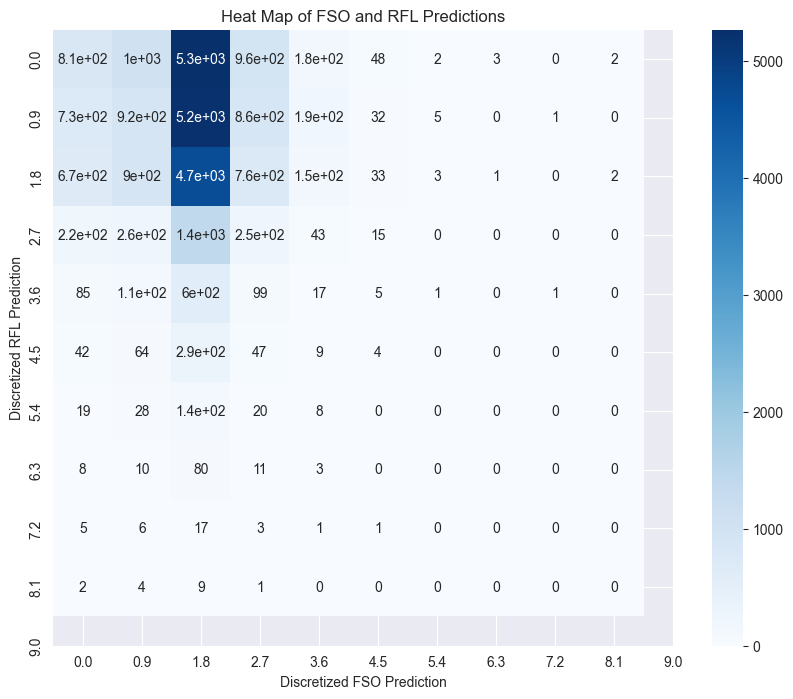

In [70]:
# Visualize the heatmap
visualize_heatmap(fso_discretized, rfl_discretized, n_bins=10)

In [71]:
def calculate_correlation_and_mutual_information_general(test_data, models, best_features, pred_column, n_bins=10):
    """
    Calculate Pearson correlation coefficients and mutual information ratios for each SYNOPCode.

    Parameters:
    test_data (pd.DataFrame): Test dataset containing SYNOPCode and the specified predicted column.
    models (dict): Dictionary of trained models (RFL or FSO) by SYNOPCode.
    best_features (dict): Dictionary of best features for the models by SYNOPCode.
    pred_column (str): The column name of the predicted values to compare against.
    n_bins (int): Number of bins to discretize the predictions.

    Returns:
    tuple: A tuple containing correlation coefficients and mutual information ratios for each SYNOPCode.
    """
    correlation_coeffs = []
    info_ratios = []

    def discretize_data(values, n_bins):
        """Discretize continuous data into bins."""
        est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
        values = np.array(values).reshape(-1, 1)
        return est.fit_transform(values).flatten()

    def calculate_entropy(values):
        """Calculate the entropy of a single variable."""
        _, counts = np.unique(values, return_counts=True)
        return entropy(counts)

    def joint_entropy(x, y):
        """Calculate the joint entropy of two variables."""
        xy = np.array(list(zip(x, y)))
        _, counts = np.unique(xy, axis=0, return_counts=True)
        return entropy(counts)

    for key, test_subset in test_data.groupby('SYNOPCode'):
        key = f'data_{int(key)}'

        if key in models:  # Check if a corresponding model exists
            # Extract model
            model = models[key]

            # Extract the predicted values and corresponding true labels and predictions
            reference_pred = test_subset[pred_column].values
            X_test = test_subset[best_features[key]]
            model_pred = model.predict(X_test)

            # Make sure the length is consistent
            if len(reference_pred) == len(model_pred):
                # Calculate the Pearson correlation coefficient
                pearson_corr, _ = pearsonr(reference_pred, model_pred)
                correlation_coeffs.append((key, pearson_corr))

                # Calculate univariate entropy
                reference_discretized = discretize_data(reference_pred, n_bins)
                model_discretized = discretize_data(model_pred, n_bins)
                entropy_reference = calculate_entropy(reference_discretized)
                entropy_model = calculate_entropy(model_discretized)

                # Calculate joint entropy and mutual information
                joint_entropy_value = joint_entropy(reference_discretized, model_discretized)
                mutual_info_value = entropy_reference + entropy_model - joint_entropy_value

                # Calculate the mutual information ratio and add to the list
                info_ratio = mutual_info_value / joint_entropy_value if joint_entropy_value != 0 else 0
                info_ratios.append((key, info_ratio))

    return correlation_coeffs, info_ratios


In [72]:
correlation_coeffs_rfl, info_ratios_rfl = calculate_correlation_and_mutual_information_general(
    test_data=test_data,
    models=models_rfl,
    best_features=best_features_rfl,
    pred_column='FSO_Pred',  # Compare RFL model predictions to FSO predictions
    n_bins=10
)

print("RFL Correlation Coefficients by SYNOPCode:")
for key, coeff in correlation_coeffs_rfl:
    print(f"SYNOPCode {key}: {coeff:.4f}")

print("\nRFL Mutual Information Ratios by SYNOPCode:")
for key, ratio in info_ratios_rfl:
    print(f"SYNOPCode {key}: {ratio:.4f}")


RFL Correlation Coefficients by SYNOPCode:
SYNOPCode data_0: -0.1536
SYNOPCode data_3: -0.3370
SYNOPCode data_4: 0.5807
SYNOPCode data_5: -0.2254
SYNOPCode data_6: 0.3004
SYNOPCode data_7: 0.8773
SYNOPCode data_8: -0.2597

RFL Mutual Information Ratios by SYNOPCode:
SYNOPCode data_0: 0.0933
SYNOPCode data_3: 0.2234
SYNOPCode data_4: 0.2237
SYNOPCode data_5: 0.1268
SYNOPCode data_6: 0.0663
SYNOPCode data_7: 0.2803
SYNOPCode data_8: 0.1226


In [73]:
import matplotlib.pyplot as plt

def plot_correlation_and_information(correlation_coeffs, info_ratios):
    """
    Plot correlation coefficients and mutual information ratios by SYNOPCode.

    Parameters:
    correlation_coeffs (list): List of tuples containing SYNOPCode and correlation coefficient.
    info_ratios (list): List of tuples containing SYNOPCode and mutual information ratio.

    Returns:
    None
    """
    synop_codes = [key for key, _ in correlation_coeffs]
    correlation_values = [abs(coeff) for _, coeff in correlation_coeffs]  # Use absolute values
    info_ratio_values = [ratio for _, ratio in info_ratios]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot Pearson correlation coefficients
    ax1.set_xlabel('SYNOPCode', fontsize=14)
    ax1.set_ylabel('Correlation Coefficient (|r|)', color='tab:blue', fontsize=14)

    for synop_code, corr_value, original_corr in zip(
        synop_codes, correlation_values, [coeff for _, coeff in correlation_coeffs]
    ):
        marker = 'o' if original_corr >= 0 else 'v'
        ax1.scatter(synop_code, corr_value, color='tab:blue', marker=marker, label='Correlation Coeff.')

    ax1.set_ylim(0, 1)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    correlation_levels = [0.7, 0.5, 0.3]
    labels = ['High Correlation', 'Moderate Correlation', 'Low Correlation']

    for level, label in zip(correlation_levels, labels):
        ax1.axhline(y=level, color='gray', linestyle='--', linewidth=0.5)
        ax1.text(-0.5, level, label, color='gray', verticalalignment='bottom', fontsize=10)

    # Plot mutual information ratios
    ax2 = ax1.twinx()
    ax2.set_ylabel('Mutual Information Ratio', color='tab:red', fontsize=14)
    ax2.scatter(synop_codes, info_ratio_values, color='tab:red', label='Mutual Information Ratio')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    # Add legend
    handles1 = [
        plt.Line2D([0], [0], marker='o', color='blue', label='Positive Correlation', linestyle='None'),
        plt.Line2D([0], [0], marker='v', color='blue', label='Negative Correlation', linestyle='None')
    ]
    handles2 = [
        plt.Line2D([0], [0], marker='o', color='red', label='Mutual Information Ratio', linestyle='None')
    ]

    fig.legend(handles=handles1 + handles2, loc='upper right', fontsize=12)
    plt.title('Correlation Coefficient and Mutual Information Ratio by SYNOPCode', fontsize=16)
    plt.tight_layout()
    plt.show()

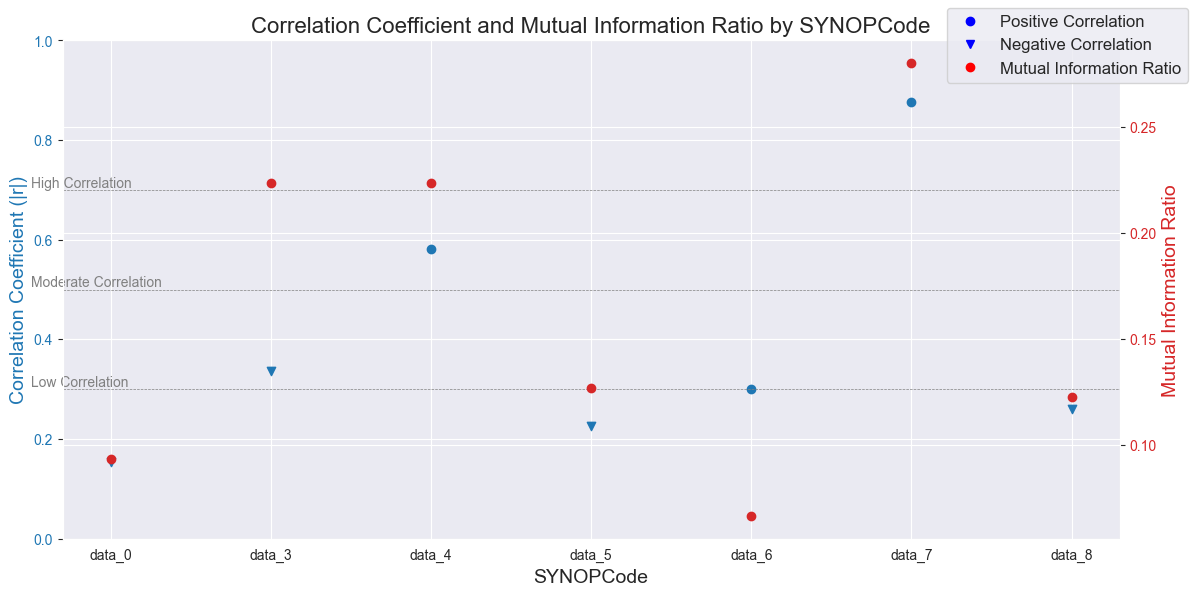

In [74]:
# Plot
plot_correlation_and_information(correlation_coeffs_rfl, info_ratios_rfl)

## FSO_Pre_RFL Model

In [75]:
best_features_rfl = {
    'data_0': ['Distance', 'Frequency', 'TemperatureMax', 'Time'],
    'data_3': ['RelativeHumidity', 'TemperatureDifference', 'Time', 'TemperatureMax'],
    'data_4': ['Visibility', 'Frequency', 'AbsoluteHumidity', 'VisibilityMin', 'Temperature'],
    'data_5': ['Distance', 'Frequency', 'AbsoluteHumidityMax', 'AbsoluteHumidity', 'ParticulateMax'],
    'data_6': ['Particulate', 'Distance', 'TemperatureMax', 'VisibilityMin', 'AbsoluteHumidity'],
    'data_7': ['Time', 'RelativeHumidity', 'RainIntensityMax', 'RainIntensity', 'TemperatureDifference'],
    'data_8': ['Distance', 'AbsoluteHumidityMax', 'TemperatureDifference', 'Frequency', 'RainIntensityMin']
}

# Train FSO models
models_rfl, total_y_true_rfl, total_y_pred_rfl, total_r2_rfl, total_rmse_rfl = train_models(
    data_by_synop=data_by_synop,
    best_features=best_features_rfl,
    target='RFL_Att',
    param_grid=param_grid
)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_0: 0.9284, RMSE: 0.6833
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_3: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_3: 0.9630, RMSE: 0.5234
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
R² for data_4: 0.7626, RMSE: 0.9381
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_5: 0.8879, RMSE: 0.9428
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_6: 0.7392, RMSE: 2.0582
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_7: {'m

In [76]:
# Add the 'FSO_Pred' column to the dataset
for key, data_subset in data_by_synop.items():
    if key in models_rfl:
        rfl_model = models_rfl[key]
        features_rfl = best_features_rfl[key]

        # Create a copy of the DataFrame to avoid the warning
        data_by_synop[key] = data_subset.copy()
        data_by_synop[key]['RFL_Pred'] = rfl_model.predict(data_subset[features_rfl])

In [77]:
best_features_fso = {
    'data_0': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature', 'RFL_Pred'],
    'data_3': ['VisibilityMax', 'RelativeHumidity', 'Distance', 'Time', 'RFL_Pred'],
    'data_4': ['Distance', 'TemperatureMin', 'TemperatureDifference', 'VisibilityMax', 'ParticulateMin', 'Time', 'RFL_Pred'],
    'data_5': ['VisibilityMax', 'Temperature', 'VisibilityMin', 'ParticulateMax', 'RFL_Pred'],
    'data_6': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature', 'RFL_Pred'],
    'data_7': ['Temperature', 'TemperatureDifference', 'Particulate', 'TemperatureMin', 'ParticulateMin', 'RFL_Pred'],
    'data_8': ['Distance', 'Visibility', 'AbsoluteHumidityMax', 'VisibilityMax', 'RelativeHumidity', 'RFL_Pred']
}

# Train RFL models
# Train FSO models
models_fso, total_y_true_fso, total_y_pred_fso, total_r2_fso, total_rmse_fso = train_models(
    data_by_synop=data_by_synop,
    best_features=best_features_fso,
    target='FSO_Att',
    param_grid=param_grid
)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
R² for data_0: 0.7834, RMSE: 1.6415
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_3: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_3: 0.8820, RMSE: 2.7240
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
R² for data_4: 0.9589, RMSE: 0.8266
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_5: 0.8807, RMSE: 1.2756
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_6: 0.8372, RMSE: 1.7544
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_7: {'

In [78]:
# === 1. Make predictions using the RFL model on the test set and add the RFL_Pred feature ===
for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_rfl:  # Check if a corresponding RFL model exists
        rfl_model = models_rfl[key]
        features_rfl = best_features_rfl[key]

        # Use the RFL model to make predictions on the test set and add RFL_Pred features
        rfl_pred = rfl_model.predict(test_subset[features_rfl])
        test_data.loc[test_subset.index, 'RFL_Pred'] = rfl_pred

print("The RFL model prediction is complete and the RFL_Pred feature has been added to the test data.")

The RFL model prediction is complete and the RFL_Pred feature has been added to the test data.


In [79]:
# === 2. The FSO model is used on the test set for prediction and performance is calculated ===
total_y_true_fso = []
total_y_pred_fso = []

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_fso:  # Check if a corresponding FSO model exists
        fso_model = models_fso[key]
        features_fso = best_features_fso[key]

        # Extract the features and labels of the test set
        X_test_fso = test_subset[features_fso]
        y_test_fso = test_subset['FSO_Att']

        # Prediction using FSO model
        y_pred_fso = fso_model.predict(X_test_fso)

        # Accumulate true and predicted values
        total_y_true_fso.extend(y_test_fso)
        total_y_pred_fso.extend(y_pred_fso)

        print(f"FSO predict complete：{key}")

# === 3. Calculate the total R² and RMSE ===
total_r2_fso = r2_score(total_y_true_fso, total_y_pred_fso)
total_rmse_fso = root_mean_squared_error(total_y_true_fso, total_y_pred_fso)

print(f"Total FSO Model - R2 Score: {total_r2_fso:.4f}")
print(f"Total FSO Model - RMSE: {total_rmse_fso:.4f}")

FSO predict complete：data_0
FSO predict complete：data_3
FSO predict complete：data_4
FSO predict complete：data_5
FSO predict complete：data_6
FSO predict complete：data_7
FSO predict complete：data_8
Total FSO Model - R2 Score: 0.8220
Total FSO Model - RMSE: 1.6321


In [80]:
# === 2. Use FSO model on test set for prediction and calculate performance ===
performance_metrics_fso = {}

for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f'data_{int(key)}'

    if key in models_fso:  # Check if a corresponding FSO model exists
        fso_model = models_fso[key]
        features_fso = best_features_fso[key]  # Extract the corresponding best features

        # Extract the features and labels of the test set
        X_test_fso = test_subset[features_fso]
        y_test_fso = test_subset['FSO_Att']

        # Prediction using FSO model
        y_pred_fso = fso_model.predict(X_test_fso)

        # Calculate the R² and RMSE for each SYNOPCode
        r2 = r2_score(y_test_fso, y_pred_fso)
        rmse = root_mean_squared_error(y_test_fso, y_pred_fso)

        # Store the result in a dictionary
        performance_metrics_fso[key] = {'R2': r2, 'RMSE': rmse}

        print(f"FSO predict complete：{key}")
        print(f"SYNOPCode {key} - R2 Score: {r2:.4f}")
        print(f"SYNOPCode {key} - RMSE: {rmse:.4f}")

# Prints the performance of each SYNOPCode
for synop_code, metrics in performance_metrics_fso.items():
    print(f"SYNOPCode {synop_code} - R2 Score: {metrics['R2']:.4f}, RMSE: {metrics['RMSE']:.4f}")


FSO predict complete：data_0
SYNOPCode data_0 - R2 Score: 0.7767
SYNOPCode data_0 - RMSE: 1.6360
FSO predict complete：data_3
SYNOPCode data_3 - R2 Score: 0.9155
SYNOPCode data_3 - RMSE: 2.5595
FSO predict complete：data_4
SYNOPCode data_4 - R2 Score: 0.9676
SYNOPCode data_4 - RMSE: 0.6991
FSO predict complete：data_5
SYNOPCode data_5 - R2 Score: 0.8479
SYNOPCode data_5 - RMSE: 1.4071
FSO predict complete：data_6
SYNOPCode data_6 - R2 Score: 0.8403
SYNOPCode data_6 - RMSE: 1.7088
FSO predict complete：data_7
SYNOPCode data_7 - R2 Score: 0.9328
SYNOPCode data_7 - RMSE: 1.5023
FSO predict complete：data_8
SYNOPCode data_8 - R2 Score: 0.9018
SYNOPCode data_8 - RMSE: 1.1998
SYNOPCode data_0 - R2 Score: 0.7767, RMSE: 1.6360
SYNOPCode data_3 - R2 Score: 0.9155, RMSE: 2.5595
SYNOPCode data_4 - R2 Score: 0.9676, RMSE: 0.6991
SYNOPCode data_5 - R2 Score: 0.8479, RMSE: 1.4071
SYNOPCode data_6 - R2 Score: 0.8403, RMSE: 1.7088
SYNOPCode data_7 - R2 Score: 0.9328, RMSE: 1.5023
SYNOPCode data_8 - R2 Score:

In [81]:
# === 4. Calculate the Pearson correlation coefficient between RFL and FSO predictions ===

# Extract all RFL_Pred and FSO_Pred (i.e. y_pred_fso) from the test data as two vectors
rfl_pred_all = test_data['RFL_Pred'].values  # RFL predict
fso_pred_all = np.array(total_y_pred_fso)  # FSO predict

if len(rfl_pred_all) == len(fso_pred_all):
    # Calculate the Pearson correlation coefficient
    pearson_corr, p_value = pearsonr(rfl_pred_all, fso_pred_all)
    print(f"Pearson Correlation (RFL vs FSO): {pearson_corr:.4f}")
    print(f"P-value: {p_value:.4f}")
else:
    print("The predicted lengths of the RFL and FSO are inconsistent and the Pearson correlation coefficients cannot be calculated.")

Pearson Correlation (RFL vs FSO): 0.0037
P-value: 0.5379


In [82]:
# Assuming fso_pred_all and rfl_pred_all are your predictions from FSO and RFL models.
entropy_fso, entropy_rfl, joint_entropy_fso_rfl, mutual_info, fso_discretized, rfl_discretized = calculate_discretized_mutual_information(
    fso_predictions=fso_pred_all,
    rfl_predictions=rfl_pred_all,
    n_bins=10
)

print(f"Entropy of FSO Predictions: {entropy_fso:.4f}")
print(f"Entropy of RFL Predictions: {entropy_rfl:.4f}")
print(f"Joint Entropy (FSO & RFL): {joint_entropy_fso_rfl:.4f}")
print(f"Mutual Information (FSO vs RFL): {mutual_info:.4f}")

Entropy of FSO Predictions: 1.5159
Entropy of RFL Predictions: 1.0915
Joint Entropy (FSO & RFL): 2.6064
Mutual Information (FSO vs RFL): 0.0009


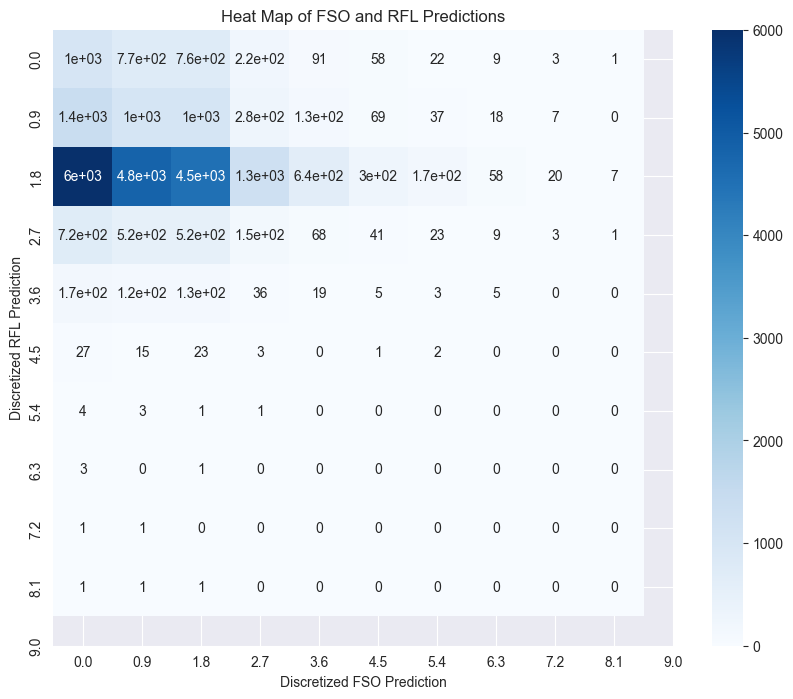

In [83]:
# Visualize the heatmap
visualize_heatmap(rfl_discretized, fso_discretized, n_bins=10)

In [86]:
correlation_coeffs_fso, info_ratios_fso = calculate_correlation_and_mutual_information_general(
    test_data=test_data,
    models=models_fso,
    best_features=best_features_fso,
    pred_column='RFL_Pred',  # Compare RFL model predictions to FSO predictions
    n_bins=10
)

print("FSO Correlation Coefficients by SYNOPCode:")
for key, coeff in correlation_coeffs_fso:
    print(f"SYNOPCode {key}: {coeff:.4f}")

print("\nFSO Mutual Information Ratios by SYNOPCode:")
for key, ratio in info_ratios_fso:
    print(f"SYNOPCode {key}: {ratio:.4f}")

FSO Correlation Coefficients by SYNOPCode:
SYNOPCode data_0: -0.3433
SYNOPCode data_3: -0.4177
SYNOPCode data_4: 0.5418
SYNOPCode data_5: -0.2572
SYNOPCode data_6: 0.4001
SYNOPCode data_7: 0.8878
SYNOPCode data_8: -0.3094

FSO Mutual Information Ratios by SYNOPCode:
SYNOPCode data_0: 0.1030
SYNOPCode data_3: 0.2080
SYNOPCode data_4: 0.2023
SYNOPCode data_5: 0.1309
SYNOPCode data_6: 0.0935
SYNOPCode data_7: 0.2987
SYNOPCode data_8: 0.1193


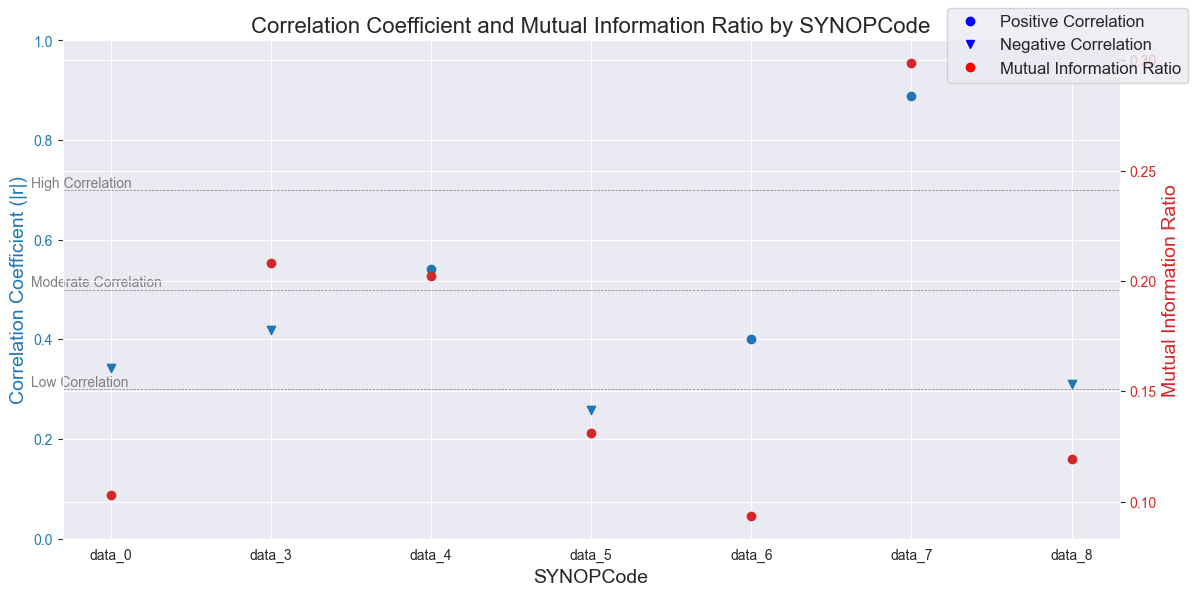

In [87]:
# Plot
plot_correlation_and_information(correlation_coeffs_fso, info_ratios_fso)

## Specific Model

In [88]:
best_features_fso = {
    'data_0': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature'],
    'data_3': ['VisibilityMax', 'RelativeHumidity', 'Distance', 'Time'],
    'data_4': ['Distance', 'TemperatureMin', 'TemperatureDifference', 'VisibilityMax', 'ParticulateMin', 'Time'],
    'data_5': ['VisibilityMax', 'Temperature', 'VisibilityMin', 'ParticulateMax'],
    'data_6': ['Visibility', 'AbsoluteHumidityMin', 'TemperatureMax', 'TemperatureMin', 'VisibilityMin', 'Temperature'],
    'data_7': ['Temperature', 'TemperatureDifference', 'Particulate', 'TemperatureMin', 'ParticulateMin'],
    'data_8': ['Distance', 'Visibility', 'AbsoluteHumidityMax', 'VisibilityMax', 'RelativeHumidity']
}

best_features_rfl = {
    'data_0': ['Distance', 'Frequency', 'TemperatureMax', 'Time'],
    'data_3': ['RelativeHumidity', 'TemperatureDifference', 'Time', 'Temperature', 'AbsoluteHumidity', 'TemperatureMin', 'AbsoluteHumidityMin', 'TemperatureMax'],
    'data_4': ['Visibility', 'Frequency', 'AbsoluteHumidity', 'VisibilityMin', 'Temperature', 'AbsoluteHumidityMax', 'AbsoluteHumidityMin'],
    'data_5': ['Distance', 'Frequency', 'AbsoluteHumidityMax', 'AbsoluteHumidity', 'ParticulateMax', 'VisibilityMin', 'VisibilityMax'],
    'data_6': ['Particulate', 'Distance', 'TemperatureMax', 'VisibilityMin', 'AbsoluteHumidity', 'RainIntensity', 'AbsoluteHumidityMax', 'RainIntensityMax', 'Temperature'],
    'data_7': ['Time', 'RelativeHumidity', 'RainIntensityMax', 'RainIntensity', 'TemperatureDifference', 'RainIntensityMin'],
    'data_8': ['Distance', 'AbsoluteHumidityMax', 'TemperatureDifference', 'Frequency', 'RainIntensityMin', 'RainIntensity', 'RainIntensityMax', 'WindSpeed', 'Temperature']
}

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 7, 10]
}

In [89]:
# Group data by SYNOPCode
data_by_synop = {f"data_{i}": train_data[train_data['SYNOPCode'] == i] for i in [0, 3, 4, 5, 6, 7, 8]}

# Train RFL models
models_rfl, total_y_true_rfl, total_y_pred_rfl, total_r2_rfl, total_rmse_rfl = train_models(
    data_by_synop=data_by_synop,
    best_features=best_features_rfl,
    target='RFL_Att',
    param_grid=param_grid
)

# Train FSO models
models_fso, total_y_true_fso, total_y_pred_fso, total_r2_fso, total_rmse_fso = train_models(
    data_by_synop=data_by_synop,
    best_features=best_features_fso,
    target='FSO_Att',
    param_grid=param_grid
)

# Print total performance metrics
print(f"Total RFL Model - R2 Score: {total_r2_rfl:.4f}")
print(f"Total RFL Model - RMSE: {total_rmse_rfl:.4f}")
print(f"Total FSO Model - R2 Score: {total_r2_fso:.4f}")
print(f"Total FSO Model - RMSE: {total_rmse_fso:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_0: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_0: 0.9284, RMSE: 0.6833
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_3: {'max_depth': 7, 'max_features': 'log2', 'n_estimators': 200}
R² for data_3: 0.9619, RMSE: 0.5312
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_4: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 50}
R² for data_4: 0.7407, RMSE: 0.9804
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_5: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_5: 0.8950, RMSE: 0.9122
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_6: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 200}
R² for data_6: 0.9140, RMSE: 1.1823
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best model for data_7: {'m

In [96]:
# === 4. Calculate the Pearson correlation coefficient between RFL and FSO predictions ===
# Add RFL_Pred and FSO_Pred to the test dataset
for key, test_subset in test_data.groupby('SYNOPCode'):
    key = f"data_{int(key)}"
    if key in models_rfl:
        # Add RFL predictions
        rfl_model = models_rfl[key]
        test_data.loc[test_subset.index, 'RFL_Pred'] = rfl_model.predict(test_subset[best_features_rfl[key]])
    if key in models_fso:
        # Add FSO predictions
        fso_model = models_fso[key]
        test_data.loc[test_subset.index, 'FSO_Pred'] = fso_model.predict(test_subset[best_features_fso[key]])

# Extract RFL_Pred and FSO_Pred from the test data
rfl_pred_all = test_data['RFL_Pred'].values
fso_pred_all = test_data['FSO_Pred'].values

# Ensure the lengths are consistent
if len(rfl_pred_all) == len(fso_pred_all):
    # Calculate the Pearson correlation coefficient
    pearson_corr, p_value = pearsonr(rfl_pred_all, fso_pred_all)
    print(f"Pearson Correlation (RFL vs FSO): {pearson_corr:.4f}")
    print(f"P-value: {p_value:.4f}")
else:
    print("The predicted lengths of RFL and FSO are inconsistent, Pearson correlation cannot be calculated.")


Pearson Correlation (RFL vs FSO): 0.1161
P-value: 0.0000


In [97]:
# Assuming fso_pred_all and rfl_pred_all are your predictions from FSO and RFL models.
entropy_fso, entropy_rfl, joint_entropy_fso_rfl, mutual_info, fso_discretized, rfl_discretized = calculate_discretized_mutual_information(
    fso_predictions=fso_pred_all,
    rfl_predictions=rfl_pred_all,
    n_bins=10
)

print(f"Entropy of FSO Predictions: {entropy_fso:.4f}")
print(f"Entropy of RFL Predictions: {entropy_rfl:.4f}")
print(f"Joint Entropy (FSO & RFL): {joint_entropy_fso_rfl:.4f}")
print(f"Mutual Information (FSO vs RFL): {mutual_info:.4f}")



Entropy of FSO Predictions: 1.5280
Entropy of RFL Predictions: 1.1678
Joint Entropy (FSO & RFL): 2.5382
Mutual Information (FSO vs RFL): 0.1576


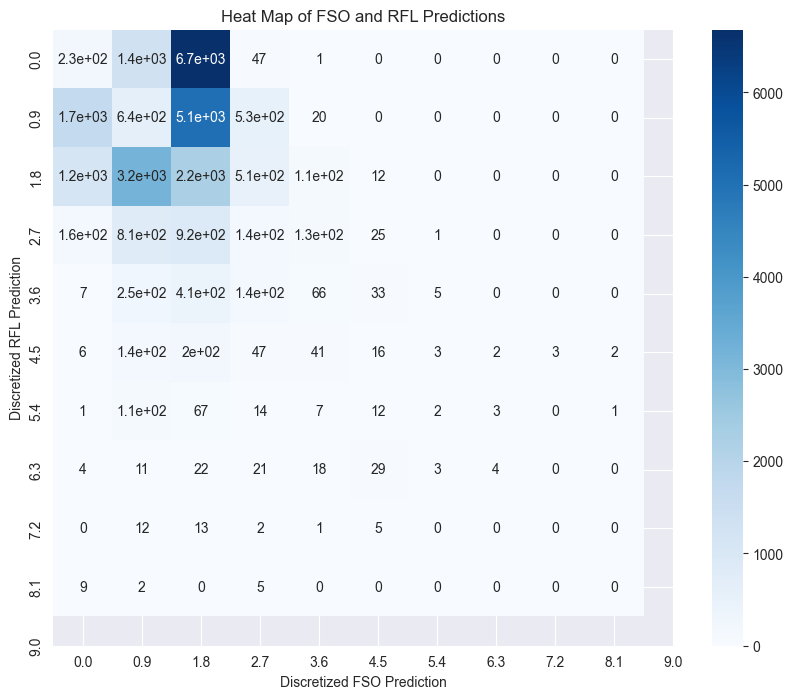

In [98]:
# Visualize the heatmap
visualize_heatmap(fso_discretized, rfl_discretized, n_bins=10)

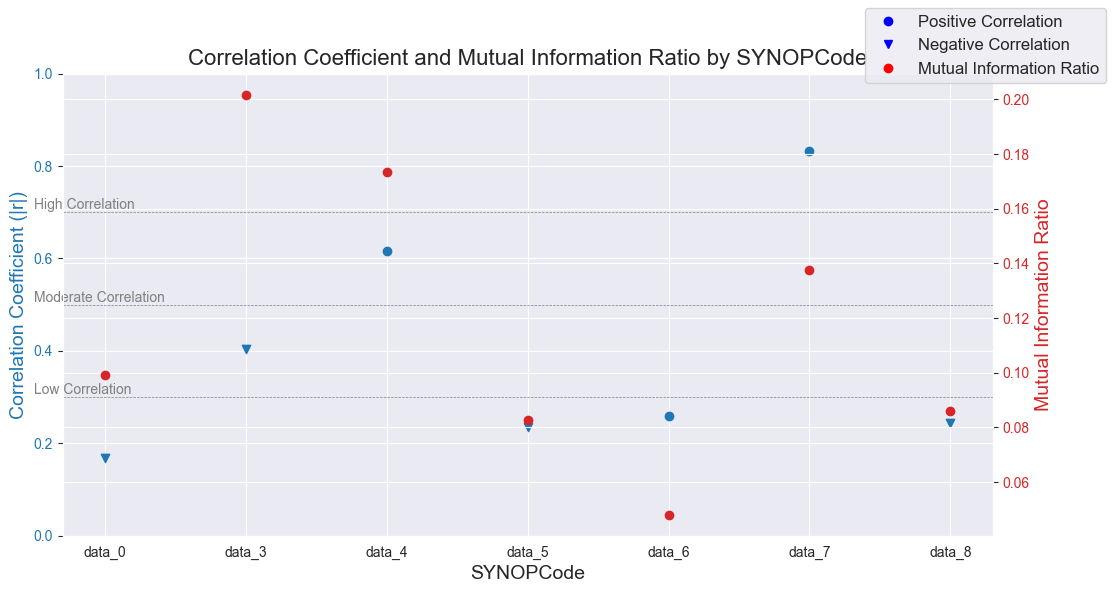

In [91]:
# Calculate Pearson correlation coefficient and mutual information
correlation_coeffs, info_ratios = [], []
for i in [0, 3, 4, 5, 6, 7, 8]:
    data_subset = data_by_synop[f'data_{i}']

    # predict for RFL and FSO model
    rfl_pred = models_rfl[f'data_{i}'].predict(data_subset[best_features_rfl[f'data_{i}']])
    fso_pred = models_fso[f'data_{i}'].predict(data_subset[best_features_fso[f'data_{i}']])

    # Calculate the Pearson correlation coefficient
    pearson_corr, _ = pearsonr(rfl_pred, fso_pred)
    correlation_coeffs.append((f'data_{i}', pearson_corr))

    # Mutual information ratio
    rfl_discretized = KBinsDiscretizer(n_bins=10, encode='ordinal').fit_transform(rfl_pred.reshape(-1, 1)).flatten()
    fso_discretized = KBinsDiscretizer(n_bins=10, encode='ordinal').fit_transform(fso_pred.reshape(-1, 1)).flatten()

    # Joint entropy
    joint_counts = np.unique(list(zip(rfl_discretized, fso_discretized)), axis=0, return_counts=True)[1]
    joint_entropy_value = entropy(joint_counts)

    # Univariate entropy
    mutual_info = entropy(np.unique(rfl_discretized, return_counts=True)[1]) + \
                  entropy(np.unique(fso_discretized, return_counts=True)[1]) - joint_entropy_value

    # Mutual information ratio
    info_ratios.append((f'data_{i}', mutual_info / joint_entropy_value if joint_entropy_value != 0 else 0))

# Extract SYNOPCode and corresponding values
synop_codes = [key for key, _ in correlation_coeffs]
correlation_values = [abs(coeff) for _, coeff in correlation_coeffs]  # 使用绝对值
info_ratio_values = [ratio for _, ratio in info_ratios]

# plot the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot the Pearson correlation coefficient
ax1.set_xlabel('SYNOPCode', fontsize=14)
ax1.set_ylabel('Correlation Coefficient (|r|)', color='tab:blue', fontsize=14)

# Select shapes based on positive and negative values
for synop_code, corr_value, original_corr in zip(synop_codes, correlation_values, [coeff for _, coeff in correlation_coeffs]):
    marker = 'o' if original_corr >= 0 else 'v'
    ax1.scatter(synop_code, corr_value, color='tab:blue', label='Correlation Coeff.', marker=marker)

ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor='tab:blue')

correlation_levels = [0.7, 0.5, 0.3]
labels = ['High Correlation', 'Moderate Correlation', 'Low Correlation']

for level, label in zip(correlation_levels, labels):
    ax1.axhline(y=level, color='gray', linestyle='--', linewidth=0.5)
    ax1.text(-0.5, level, label, color='gray', verticalalignment='bottom', fontsize=10)

# Plot mutual information ratios
ax2 = ax1.twinx()
ax2.set_ylabel('Mutual Information Ratio', color='tab:red', fontsize=14)
ax2.scatter(synop_codes, info_ratio_values, color='tab:red', label='Mutual Information Ratio')
ax2.tick_params(axis='y', labelcolor='tab:red')

# title
plt.title('Correlation Coefficient and Mutual Information Ratio by SYNOPCode', fontsize=16)

handles1 = [plt.Line2D([0], [0], marker='o', color='blue', label='Positive Correlation', linestyle='None'),
            plt.Line2D([0], [0], marker='v', color='blue', label='Negative Correlation', linestyle='None')]
handles2 = [plt.Line2D([0], [0], marker='o', color='red', label='Mutual Information Ratio', linestyle='None')]

fig.legend(handles=handles1 + handles2, loc='upper right', fontsize=12)

plt.show()

## Test Data Set

Pearson Correlation (RFL vs FSO): 0.1161
P-value: 0.0000
Mutual Information (RFL vs FSO): 0.1576


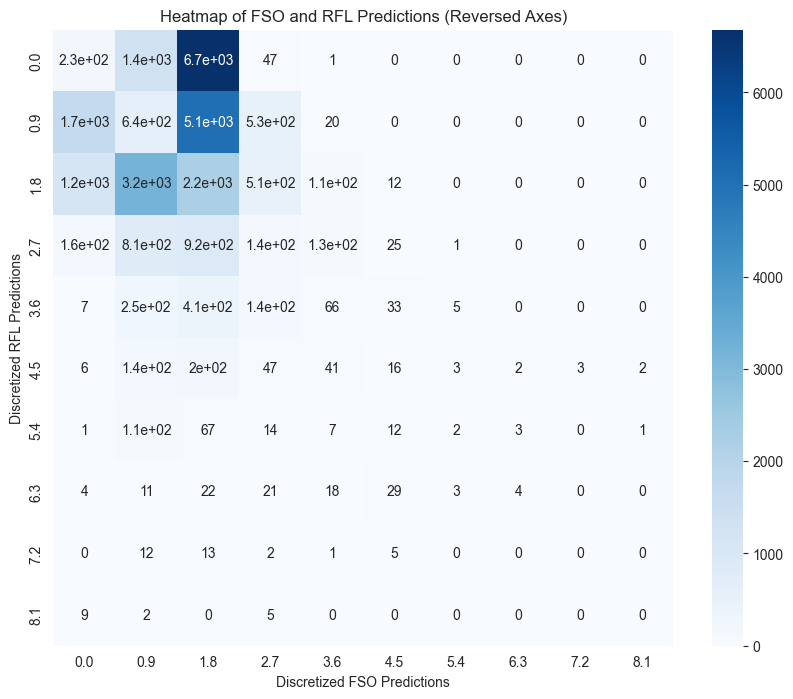

In [102]:
# Extract predictions from test data
rfl_pred_all = test_data['RFL_Pred'].values
fso_pred_all = test_data['FSO_Pred'].values

# Ensure the lengths are consistent
if len(rfl_pred_all) == len(fso_pred_all):
    # Calculate Pearson correlation
    pearson_corr, p_value = pearsonr(rfl_pred_all, fso_pred_all)
    print(f"Pearson Correlation (RFL vs FSO): {pearson_corr:.4f}")
    print(f"P-value: {p_value:.4f}")

    # Discretize the predictions
    discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
    fso_discretized = discretizer.fit_transform(fso_pred_all.reshape(-1, 1)).flatten()
    rfl_discretized = discretizer.fit_transform(rfl_pred_all.reshape(-1, 1)).flatten()

    # Calculate joint entropy
    joint_counts, x_edges, y_edges = np.histogram2d(fso_discretized, rfl_discretized, bins=10)
    joint_entropy_value = entropy(joint_counts.flatten())

    # Calculate univariate entropy
    entropy_fso = entropy(np.unique(fso_discretized, return_counts=True)[1])
    entropy_rfl = entropy(np.unique(rfl_discretized, return_counts=True)[1])

    # Calculate mutual information
    mutual_info_value = entropy_fso + entropy_rfl - joint_entropy_value
    print(f"Mutual Information (RFL vs FSO): {mutual_info_value:.4f}")

    # Plot heatmap of the joint distribution (correct axis labels and reflect the data)
    plt.figure(figsize=(10, 8))
    sns.heatmap(joint_counts,  # No need to transpose now as we already switched the axes in histogram2d
                annot=True, cmap='Blues',
                xticklabels=np.round(x_edges[:-1], 2),  # FSO as X-axis
                yticklabels=np.round(y_edges[:-1], 2))  # RFL as Y-axis
    plt.title('Heatmap of FSO and RFL Predictions (Reversed Axes)')
    plt.xlabel('Discretized FSO Predictions')  # Correct X-axis label
    plt.ylabel('Discretized RFL Predictions')  # Correct Y-axis label
    plt.show()
else:
    print("The predicted lengths of RFL and FSO are inconsistent, calculations cannot be performed.")



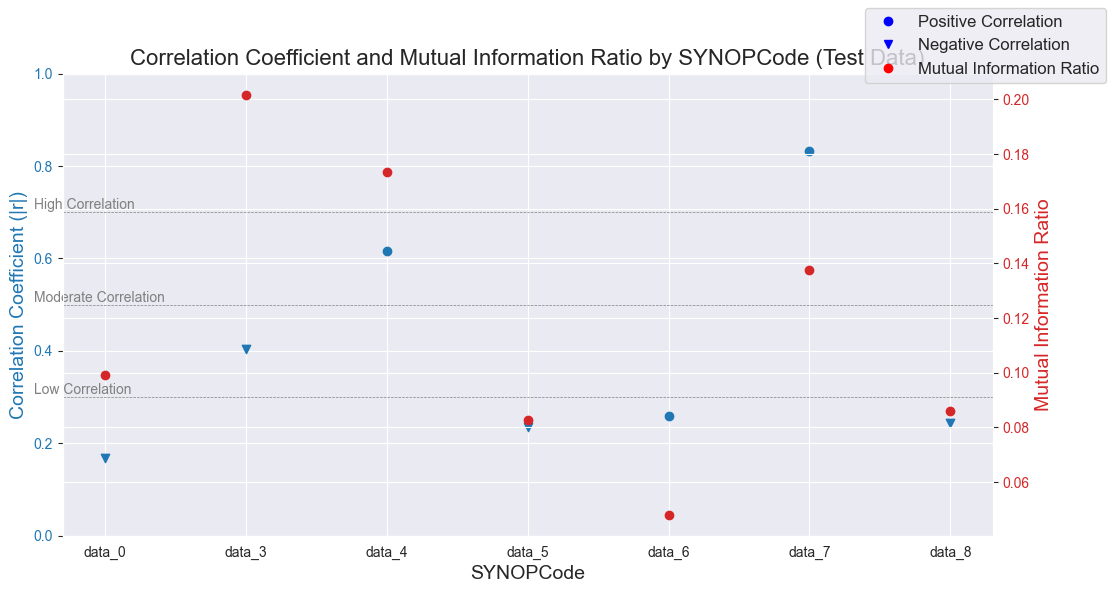

In [59]:
synop_codes = [key for key, _ in correlation_coeffs]
correlation_values = [abs(coeff) for _, coeff in correlation_coeffs]
info_ratio_values = [ratio for _, ratio in info_ratios]

# plot the figure
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Pearson correlation coefficients (shape to distinguish positive and negative)
ax1.set_xlabel('SYNOPCode', fontsize=14)
ax1.set_ylabel('Correlation Coefficient (|r|)', color='tab:blue', fontsize=14)

for synop_code, corr_value, original_corr in zip(synop_codes, correlation_values, [coeff for _, coeff in correlation_coeffs]):
    marker = 'o' if original_corr >= 0 else 'v'
    ax1.scatter(synop_code, corr_value, color='tab:blue', label='Correlation Coeff.', marker=marker)

ax1.set_ylim(0, 1)
ax1.tick_params(axis='y', labelcolor='tab:blue')

correlation_levels = [0.7, 0.5, 0.3]
labels = ['High Correlation', 'Moderate Correlation', 'Low Correlation']

for level, label in zip(correlation_levels, labels):
    ax1.axhline(y=level, color='gray', linestyle='--', linewidth=0.5)
    ax1.text(-0.5, level, label, color='gray', verticalalignment='bottom', fontsize=10)

ax2 = ax1.twinx()
ax2.set_ylabel('Mutual Information Ratio', color='tab:red', fontsize=14)
ax2.scatter(synop_codes, info_ratio_values, color='tab:red', label='Mutual Information Ratio')
ax2.tick_params(axis='y', labelcolor='tab:red')

# title
plt.title('Correlation Coefficient and Mutual Information Ratio by SYNOPCode (Test Data)', fontsize=16)

handles1 = [plt.Line2D([0], [0], marker='o', color='blue', label='Positive Correlation', linestyle='None'),
            plt.Line2D([0], [0], marker='v', color='blue', label='Negative Correlation', linestyle='None')]
handles2 = [plt.Line2D([0], [0], marker='o', color='red', label='Mutual Information Ratio', linestyle='None')]

fig.legend(handles=handles1 + handles2, loc='upper right', fontsize=12)

plt.show()